In [1]:
import sys

setupFlag = False ## Set flag to True if these aren't installed
if setupFlag:
    !{sys.executable} -m pip install astroquery
    ## https://github.com/astropy/astroquery
    !{sys.executable} -m pip install eleanor
    ## https://github.com/afeinstein20/eleanor
    !{sys.executable} -m pip install lightkurve
    ## https://github.com/KeplerGO/lightkurve

In [2]:
import csv
import dis
import inspect
import os
import sys

import astropy
import astroquery
import eleanor
#import tess_stars2px ## Currently unnecessary
import lightkurve as lk
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sp
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from scipy import linalg as la
from scipy import optimize
from scipy import integrate
from scipy import stats

from IPython.display import display_html
from IPython.display import Image

In [3]:
def mkdir(directory): ## creates a directory if it doesn't exist
    ## credit to https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def display_side_by_side(*args): ##displays pandas DataFrames side by side
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def unravel(list): ## creates an array from a list of arrays
    return np.array([i for array in list for i in array])

savePNG = True ## Changes matplotlib backend to save plots as pgf (default:True)
if savePNG:
    mpl.use("agg")
    plotExt = str('.png')
elif not savePNG:
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,})
    plotExt = str('.pgf')

notebookPlotFlag = True ## Changes Jupyter plotting backend (default:True)
if notebookPlotFlag:
    %matplotlib notebook
elif not notebookPlotFlag:
    %matplotlib inline

In [4]:
def interpToMatch(item1,item2):
    ## Function takes two pandas DataFrames with a 'time' column (float or integer type)
    ## and interpolates the data to match the set with a smaller number of points
    ## with the interpolated DataFrames being returned as a tuple
    item1_indexed = item1.set_index('time')
    item2_indexed = item2.set_index('time')
    #display(item1_indexed)
    item1_length = len(item1_indexed.index)
    item2_length = len(item2_indexed.index)
    #display(item1_length)
    if item1_length >= item2_length:
        minun = item2_indexed.index.min()
        plusle = item2_indexed.index.max()
        numPoints = item2_length
    elif item1_length <= item2_length:
        minun = item1_indexed.index.min()
        plusle = item1_indexed.index.max()
        numPoints = item1_length
    #display(minun)
    #display(plusle)
    
    #numPoints = abs(plusle-minun)
    newIndex = np.linspace(minun,plusle-1,numPoints)
    #display(numPoints)
    #display(newIndex)
    
    item1_interp = pd.DataFrame(index=newIndex)
    item1_interp.index.name = item1_indexed.index.name
    item2_interp = pd.DataFrame(index=newIndex)
    item2_interp.index.name = item2_indexed.index.name

    for colname, col in item1_indexed.iteritems():
        item1_interp[colname] = np.interp(newIndex,item1_indexed.index,col)
    for colname, col in item2_indexed.iteritems():
        item2_interp[colname] = np.interp(newIndex,item2_indexed.index,col)
    item1_interp.reset_index(inplace=True)
    item2_interp.reset_index(inplace=True)
    
    return item1_interp, item2_interp

def interpToData(data, *args):
    ## More generalized version of interpToMatch(). Takes an argument for a reference
    ## DataFrame and a variable number of DataFrames to be interpolated so that
    ## they match the time sampling of the reference DataFrame. Like interpToMatch(),
    ## DataFrames must have a 'time' column of an integer or float type.
    ## Function returns an array containing the reference DataFrame as the first
    ## item followed by the interpolated DataFrames in the order in which they were
    ## passed to the function
    interpArray = []
    interpArray.append(data)
    
    data_indexed = data.set_index('time')
    data_length = len(data_indexed.index)
    minun = data_indexed.index.min()
    plusle = data_indexed.index.max()
    newIndex = data_indexed.index
    
    for arg in args:
        arg_indexed = arg.set_index('time')
        arg_interp = pd.DataFrame(index=newIndex)
        arg_interp.index.name = arg_indexed.index.name
        for colname, col in arg_indexed.iteritems():
            arg_interp[colname] = np.interp(newIndex,arg_indexed.index,col)
        arg_interp.reset_index(inplace=True)
        interpArray.append(arg_interp)
    return interpArray

In [5]:
def lcImport(directory, head=None):
    ## This is a workaround that imports the lightcurves from Fausnaugh correctly; due to a quirk
    ## with his formatting, pandas initially sets the BTJD values to be the index and shifts the
    ## rest of the columns to the left by one.
    
    if head: ## in case there's something non-standard or want to change col names, don't expect to use this
        header = head
    elif not head: ## Fausnaugh data columns
        header = ['BTJD', 'TJD', 'cts', 'e_cts', 'bkg', 'bkg_model', 'bkg2', 'e_bkg2'] 
    
    snPandas = pd.read_csv(directory,delim_whitespace=True, header=0, names=header)
    snPandas = snPandas.shift(1,axis=1) ## Fixes issue with data shifted one col to the left
    snPandas[header[0]] = snPandas.index ## Populates BTJD col with correct data
    snPandas = snPandas.reset_index(drop=True) ## Resets index to be standard
    
    return snPandas

### SN2020bpi

In [6]:
sn2020bpi_s21_dir = './Fausnaugh/sector21/cam3_ccd2/lc/lc_2020bpi_cleaned'
sn2020bpi_s21 = lcImport(sn2020bpi_s21_dir)
sn2020bpi_s21['cts_median'] = sn2020bpi_s21['cts'].rolling(12).median()
sn2020bpi_s21['e_cts_median'] = sn2020bpi_s21['e_cts'].rolling(12).median()

In [7]:
sn2020bpi_peak_iso = Time('2020-02-14', format='iso')
sn2020bpi_peak_btjd = sn2020bpi_peak_iso.jd - 2457000.0

In [41]:
sn2020bpi_peak_iso.mjd

58893.0

<IPython.core.display.Javascript object>


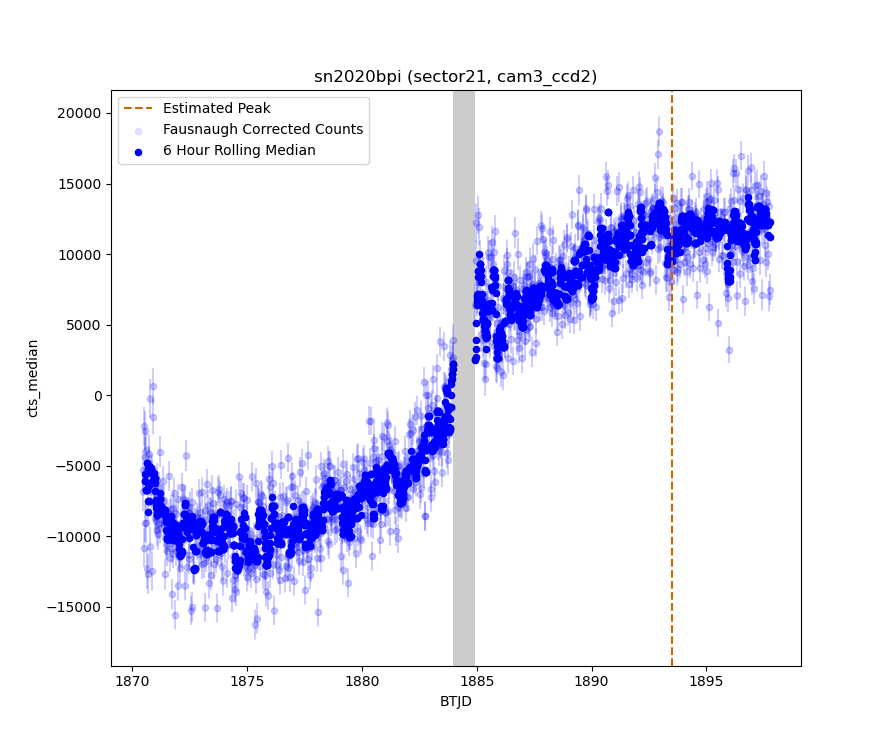

Text(0.5, 1.0, 'sn2020bpi (sector21, cam3_ccd2)')

In [37]:
ax = sn2020bpi_s21.plot(x='BTJD', y='cts', yerr='e_cts',
                      color='blue', alpha=0.1, kind='scatter', label='Fausnaugh Corrected Counts')
sn2020bpi_s21.plot(x='BTJD', y='cts_median',
                color='blue',kind='scatter',ax=ax, label='6 Hour Rolling Median')
plt.axvline(x=sn2020bpi_peak_btjd, color=(0.8,0.4,0), 
            linestyle='dashed', label='Estimated Peak')
plt.axvspan(sn2020bpi_s21['BTJD'][sn2020bpi_s21['BTJD'].diff().argmax()-1],
           sn2020bpi_s21['BTJD'][sn2020bpi_s21['BTJD'].diff().argmax()],
           facecolor='black',alpha=0.2)
plt.legend()
plt.title('sn2020bpi (sector21, cam3_ccd2)')

<IPython.core.display.Javascript object>


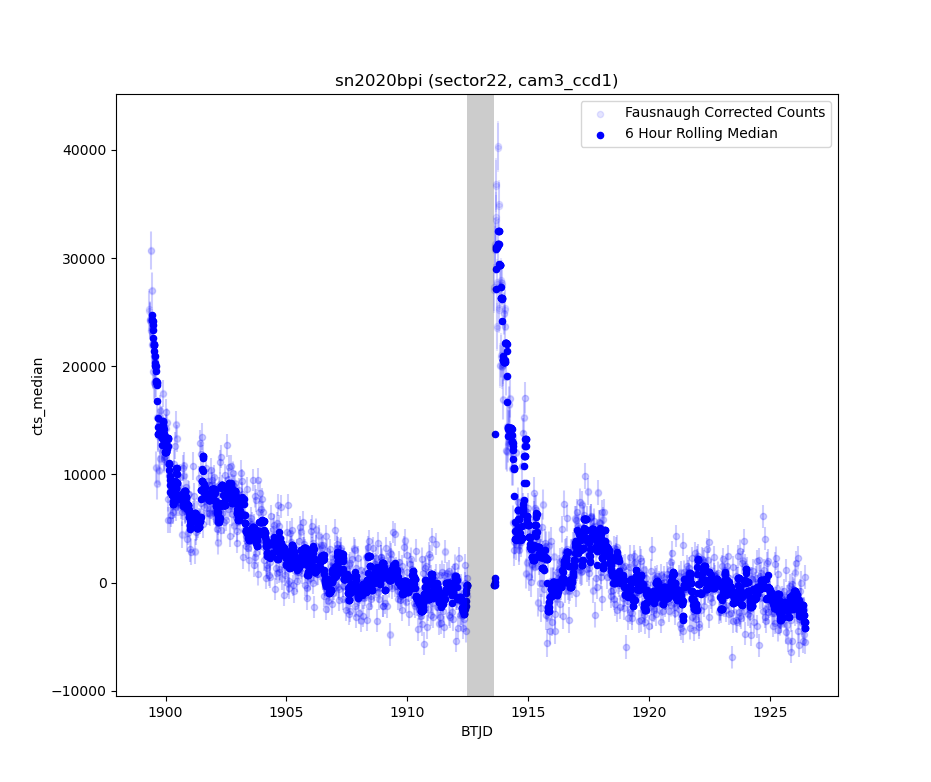

Text(0.5, 1.0, 'sn2020bpi (sector22, cam3_ccd1)')

In [38]:
sn2020bpi_s22_dir = './Fausnaugh/sector22/cam3_ccd1/lc/lc_2020bpi_cleaned'
sn2020bpi_s22 = lcImport(sn2020bpi_s22_dir)
sn2020bpi_s22['cts_median'] = sn2020bpi_s22['cts'].rolling(12).median()
sn2020bpi_s22['e_cts_median'] = sn2020bpi_s22['e_cts'].rolling(12).median()

ax = sn2020bpi_s22.plot(x='BTJD', y='cts', yerr='e_cts',
                      color='blue', alpha=0.1, kind='scatter', label='Fausnaugh Corrected Counts')
sn2020bpi_s22.plot(x='BTJD', y='cts_median',
                color='blue',kind='scatter',ax=ax, label='6 Hour Rolling Median')
plt.axvspan(sn2020bpi_s22['BTJD'][sn2020bpi_s22['BTJD'].diff().argmax()-1],
           sn2020bpi_s22['BTJD'][sn2020bpi_s22['BTJD'].diff().argmax()],
           facecolor='black',alpha=0.2)
plt.legend()
plt.title('sn2020bpi (sector22, cam3_ccd1)')

In [10]:
sn2020bpi_s21[sn2020bpi_s21['BTJD'].diff() >= 10*sn2020bpi_s21['BTJD'].diff().mean()]

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,cts_median,e_cts_median
1296,1884.94331,1884.93787,6351.9981,1443.9296,-137417.6221,2708.517,8756.0096,1443.9296,2503.6795,1024.3671


<IPython.core.display.Javascript object>


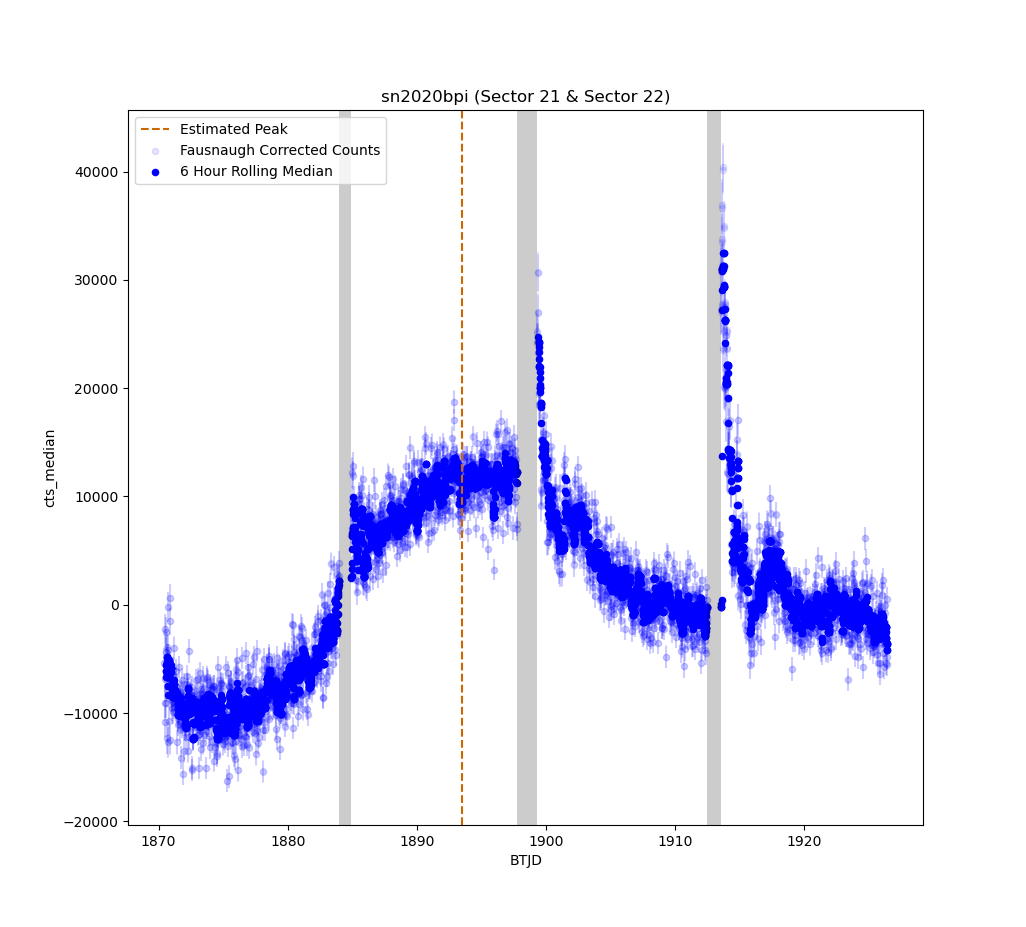

Text(0.5, 1.0, 'sn2020bpi (Sector 21 & Sector 22)')

In [11]:
sn2020bpi_s21s22 = pd.concat([sn2020bpi_s21,sn2020bpi_s22])

ax = sn2020bpi_s21s22.plot(x='BTJD', y='cts', yerr='e_cts',
                      color='blue', alpha=0.1, kind='scatter', label='Fausnaugh Corrected Counts')
sn2020bpi_s21s22.plot(x='BTJD', y='cts_median',
                color='blue',kind='scatter',ax=ax, label='6 Hour Rolling Median')
plt.axvline(x=sn2020bpi_peak_btjd, color=(0.8,0.4,0), 
            linestyle='dashed', label='Estimated Peak')
plt.axvspan(sn2020bpi_s21['BTJD'][sn2020bpi_s21['BTJD'].diff().argmax()-1],
           sn2020bpi_s21['BTJD'][sn2020bpi_s21['BTJD'].diff().argmax()],
           facecolor='black',alpha=0.2)
plt.axvspan(sn2020bpi_s22['BTJD'][sn2020bpi_s22['BTJD'].diff().argmax()-1],
           sn2020bpi_s22['BTJD'][sn2020bpi_s22['BTJD'].diff().argmax()],
           facecolor='black',alpha=0.2)
plt.axvspan(sn2020bpi_s21['BTJD'].iloc[-1],
           sn2020bpi_s22['BTJD'].iloc[0],
           facecolor='black',alpha=0.2)
plt.legend()
plt.title('sn2020bpi (Sector 21 & Sector 22)')

### SN2020jdo

In [31]:
sn2020jdo_peak_iso = Time('2020-05-16', format='iso')
sn2020jdo_peak_btjd = sn2020jdo_peak_iso.jd - 2457000.0
print(sn2020jdo_peak_btjd)

1985.5


In [34]:
sn2020jdo_s25_dir = './Fausnaugh/sector25/cam2_ccd1/lc/lc_2020jdo_cleaned'
sn2020jdo_s25 = lcImport(sn2020jdo_s25_dir)
sn2020jdo_s25['cts_median'] = sn2020jdo_s25['cts'].rolling(12).median()
sn2020jdo_s25['e_cts_median'] = sn2020jdo_s25['e_cts'].rolling(12).median()

<IPython.core.display.Javascript object>


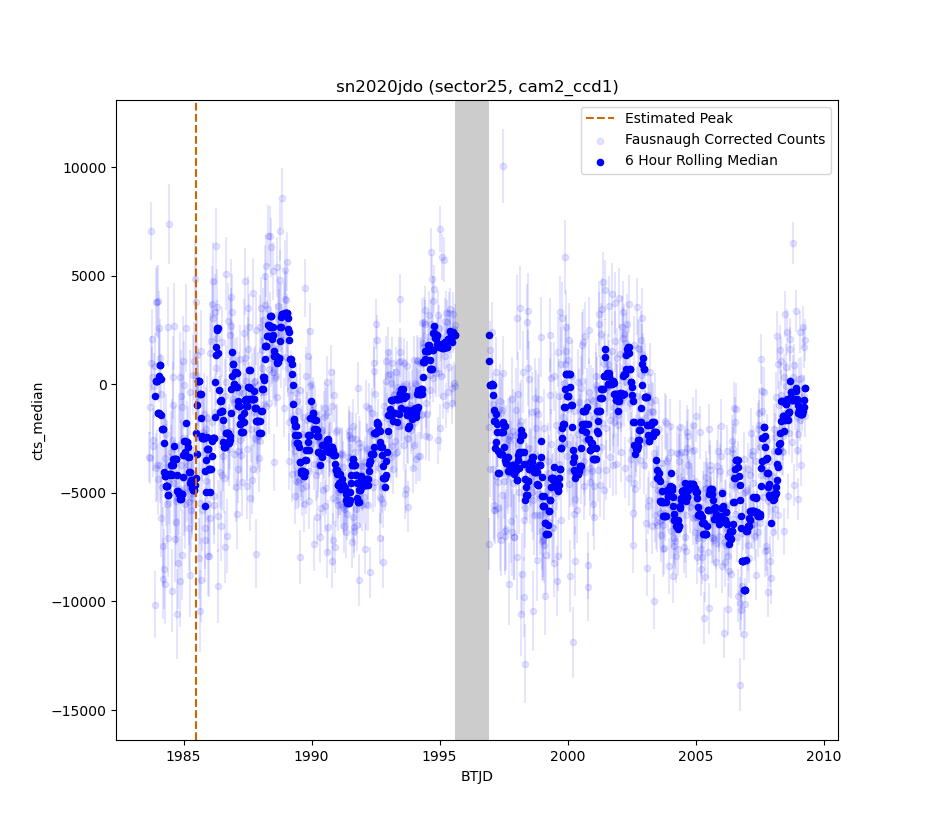

Text(0.5, 1.0, 'sn2020jdo (sector25, cam2_ccd1)')

In [36]:
ax = sn2020jdo_s25.plot(x='BTJD', y='cts', yerr='e_cts',
                      color='blue', alpha=0.1, kind='scatter', label='Fausnaugh Corrected Counts')
sn2020jdo_s25.plot(x='BTJD', y='cts_median',
                color='blue',kind='scatter',ax=ax, label='6 Hour Rolling Median')
plt.axvline(x=sn2020jdo_peak_btjd, color=(0.8,0.4,0), 
            linestyle='dashed', label='Estimated Peak')
plt.axvspan(sn2020jdo_s25['BTJD'][sn2020jdo_s25['BTJD'].diff().argmax()-1],
           sn2020jdo_s25['BTJD'][sn2020jdo_s25['BTJD'].diff().argmax()],
           facecolor='black',alpha=0.2)
plt.legend()
plt.title('sn2020jdo (sector25, cam2_ccd1)')

### SN2020kyx

In [28]:
sn2020kyx_peak_iso = Time('2020-06-09', format='iso')
sn2020kyx_peak_btjd = sn2020kyx_peak_iso.jd - 2457000.0
print(sn2020kyx_peak_btjd)

2009.5


In [29]:
sn2020kyx_s25_dir = './Fausnaugh/sector25/cam1_ccd3/lc/lc_2020kyx_cleaned'
sn2020kyx_s25 = lcImport(sn2020kyx_s25_dir)
sn2020kyx_s25['cts_median'] = sn2020kyx_s25['cts'].rolling(12).median()
sn2020kyx_s25['e_cts_median'] = sn2020kyx_s25['e_cts'].rolling(12).median()

<IPython.core.display.Javascript object>


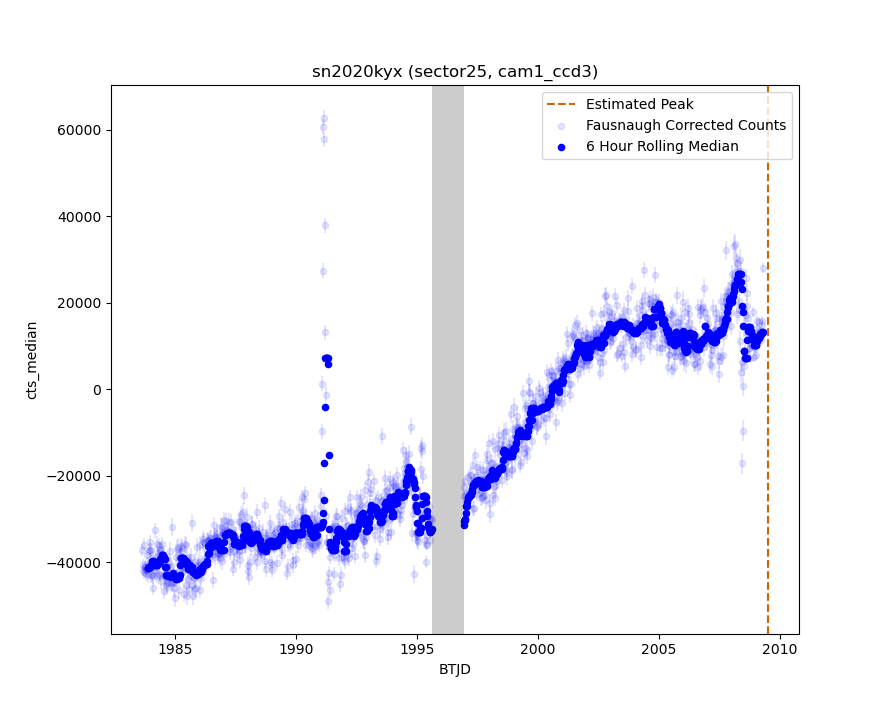

Text(0.5, 1.0, 'sn2020kyx (sector25, cam1_ccd3)')

In [39]:
ax = sn2020kyx_s25.plot(x='BTJD', y='cts', yerr='e_cts',
                      color='blue', alpha=0.1, kind='scatter', label='Fausnaugh Corrected Counts')
sn2020kyx_s25.plot(x='BTJD', y='cts_median',
                color='blue',kind='scatter',ax=ax, label='6 Hour Rolling Median')
plt.axvline(x=sn2020kyx_peak_btjd, color=(0.8,0.4,0), 
            linestyle='dashed', label='Estimated Peak')
plt.axvspan(sn2020kyx_s25['BTJD'][sn2020kyx_s25['BTJD'].diff().argmax()-1],
           sn2020kyx_s25['BTJD'][sn2020kyx_s25['BTJD'].diff().argmax()],
           facecolor='black',alpha=0.2)
plt.legend()
plt.title('sn2020kyx (sector25, cam1_ccd3)')

### SN2020ees

In [40]:
sn2020ees_peak_iso = Time('2020-03-19', format='iso')
sn2020ees_peak_btjd = sn2020ees_peak_iso.jd - 2457000.0
print(sn2020ees_peak_btjd) 

1927.5


seen in sector 23 just after peak